In [1]:
import os, sys, math, gc, random, warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

try:
  import pywt
  HAVE_PYWT = True
except Exception:
  HAVE_PYWT = False

In [2]:
df = pd.read_csv('/content/Epileptic Seizure Recognition.csv')

In [3]:
print('shape', df.shape)
display(df.head())

shape (11500, 180)


,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


Read and Show Dataset¶
The original dataset from the reference consists of 5 different folders, each with 100 files, with each file representing a single subject/person. Each file is a recording of brain activity for 23.6 seconds.

The corresponding time-series is sampled into 4097 data points. Each data point is the value of the EEG recording at a different point in time. So we have total 500 individuals with each has 4097 data points for 23.5 seconds.

We divided and shuffled every 4097 data points into 23 chunks, each chunk contains 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time.

So now we have 23 x 500 = 11500 pieces of information(row), each information contains 178 data points for 1 second(column), the last column represents the label y {1,2,3,4,5}.

The response variable is y in column 179, the Explanatory variables X1, X2, ..., X178

In [4]:
all_col = df.columns.tolist()
label_col = 'y' if 'y' in df.columns else df.columns[-1]
feature_col = [c for c in df.columns if (c != label_col and not c.startswith('Unnamed'))]
print('label column :', label_col)
print('Num feature per window:', len(feature_col))


label column : y
Num feature per window: 178


In [5]:
label_map = {1:'Seizure', 2:'TumorRegion',3:'HealthyRegion',4:'EyesClosed',5:'EyesOpen'}
df['label_name'] = df[label_col].map(label_map)
df['is_seizure'] = (df[label_col] == 1).astype(int)

In [6]:
print(df[label_col].value_counts())

y
4    2300
1    2300
5    2300
2    2300
3    2300
Name: count, dtype: int64


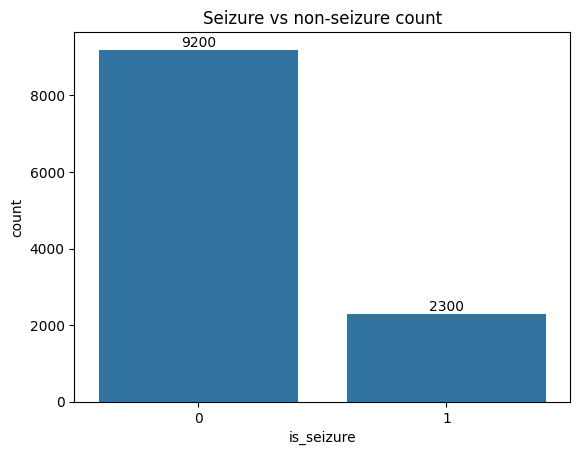

In [7]:
ax = sns.countplot(x = df['is_seizure'])
ax.bar_label(ax.containers[0])
plt.title('Seizure vs non-seizure count')
plt.show()

In [8]:
non_seizure, seizure = df['is_seizure'].value_counts()
print('The number of trials for the non-seizure class is:', non_seizure)
print('The number of trials for the seizure class is :', seizure)

The number of trials for the non-seizure class is: 9200
The number of trials for the seizure class is : 2300


In [9]:
df.isnull().sum()

,0
Unnamed,0
X1,0
X2,0
X3,0
X4,0
...,...
X177,0
X178,0
y,0
label_name,0


In [10]:
df.drop('Unnamed', axis = 1, inplace= True)

In [11]:
df.head(2)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X172,X173,X174,X175,X176,X177,X178,y,label_name,is_seizure
0,135,190,229,223,192,125,55,-9,-33,-38,...,-31,-77,-103,-127,-116,-83,-51,4,EyesClosed,0
1,386,382,356,331,320,315,307,272,244,232,...,146,152,157,156,154,143,129,1,Seizure,1


Exploratory Data Analysis (EDA)

In [12]:
vc = df[label_col].value_counts().sort_index()
vc_percent = 100*vc/vc.sum()
class_df = pd.DataFrame({'count':vc, 'percent':vc_percent, 'name':[label_map[i] for i in vc.index]})
class_df

,count,percent,name
y,,,
1,2300,20.0,Seizure
2,2300,20.0,TumorRegion
3,2300,20.0,HealthyRegion
4,2300,20.0,EyesClosed
5,2300,20.0,EyesOpen


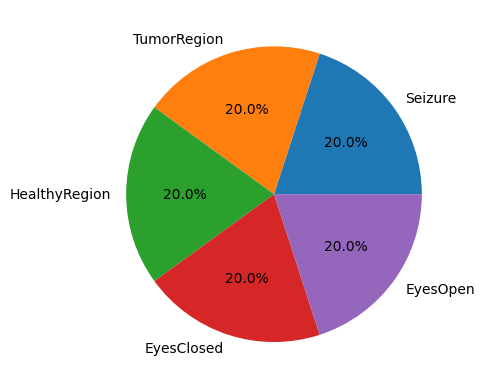

In [13]:
plt.pie(class_df['count'], labels=class_df['name'], autopct='%1.1f%%')
plt.show()

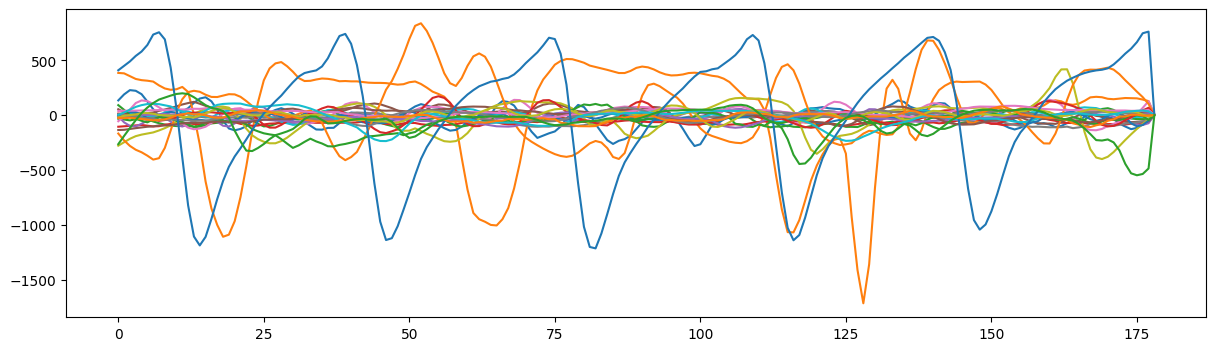

In [14]:
plt.figure(figsize=(50,4))
plt.subplot(131)
[plt.plot(df.values[i][0:179]) for i in range(23)]
plt.show()

In [15]:
df[df['is_seizure'] == 0].describe().T.head()

,count,mean,std,min,25%,50%,75%,max
X1,9200.0,-8.992609,70.455286,-566.0,-44.0,-7.0,26.0,1726.0
X2,9200.0,-8.877174,70.560110,-609.0,-44.0,-7.0,27.0,1713.0
X3,9200.0,-8.910435,70.372582,-594.0,-45.0,-7.0,28.0,1697.0
X4,9200.0,-8.969783,70.030409,-549.0,-45.0,-8.0,27.0,1612.0
X5,9200.0,-9.085326,69.377958,-603.0,-45.0,-8.0,27.0,1437.0


In [16]:
df[df['is_seizure'] == 1].describe().T.head()

,count,mean,std,min,25%,50%,75%,max
X1,2300.0,-21.936522,342.361939,-1839.0,-193.25,-16.0,159.00,1314.0
X2,2300.0,-19.049130,343.398782,-1838.0,-191.25,-18.0,168.25,1356.0
X3,2300.0,-15.293913,337.489643,-1835.0,-187.00,-12.5,169.25,1274.0
X4,2300.0,-9.836087,332.354833,-1845.0,-184.00,-6.0,166.25,1226.0
X5,2300.0,-3.707391,332.211163,-1791.0,-174.25,-12.0,170.00,1518.0


In [17]:
print('Total Mean VALUE for Epileptic: {}'.format((df[df['is_seizure'] == 1].describe().mean()).mean()))
print('Total Std VALUE for Epileptic: {}'.format((df[df['is_seizure'] == 1].describe().std()).std()))

Total Mean VALUE for Epileptic: 290.118920064668
Total Std VALUE for Epileptic: 61.26568866204571


In [18]:
print('Total Mean VALUE for NON Epileptic: {}'.format((df[df['is_seizure']== 0].describe().mean()).mean()))
print('Total Std VALUE for NON Epileptic: {}'.format((df[df['is_seizure']== 0].describe().std()).std()))

Total Mean VALUE for NON Epileptic: 1259.5026263436266
Total Std VALUE for NON Epileptic: 15.558473767994222


In [19]:
df.head(2)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X172,X173,X174,X175,X176,X177,X178,y,label_name,is_seizure
0,135,190,229,223,192,125,55,-9,-33,-38,...,-31,-77,-103,-127,-116,-83,-51,4,EyesClosed,0
1,386,382,356,331,320,315,307,272,244,232,...,146,152,157,156,154,143,129,1,Seizure,1


In [20]:
X = df.iloc[:,0:179].values
seizure = df.iloc[:,180].values
seizure_index_list = []
normal_index_list = []
for i in range(len(seizure)):
  if (seizure[i] == 1):
    seizure_index_list.append(i)
  else:
    normal_index_list.append(i)

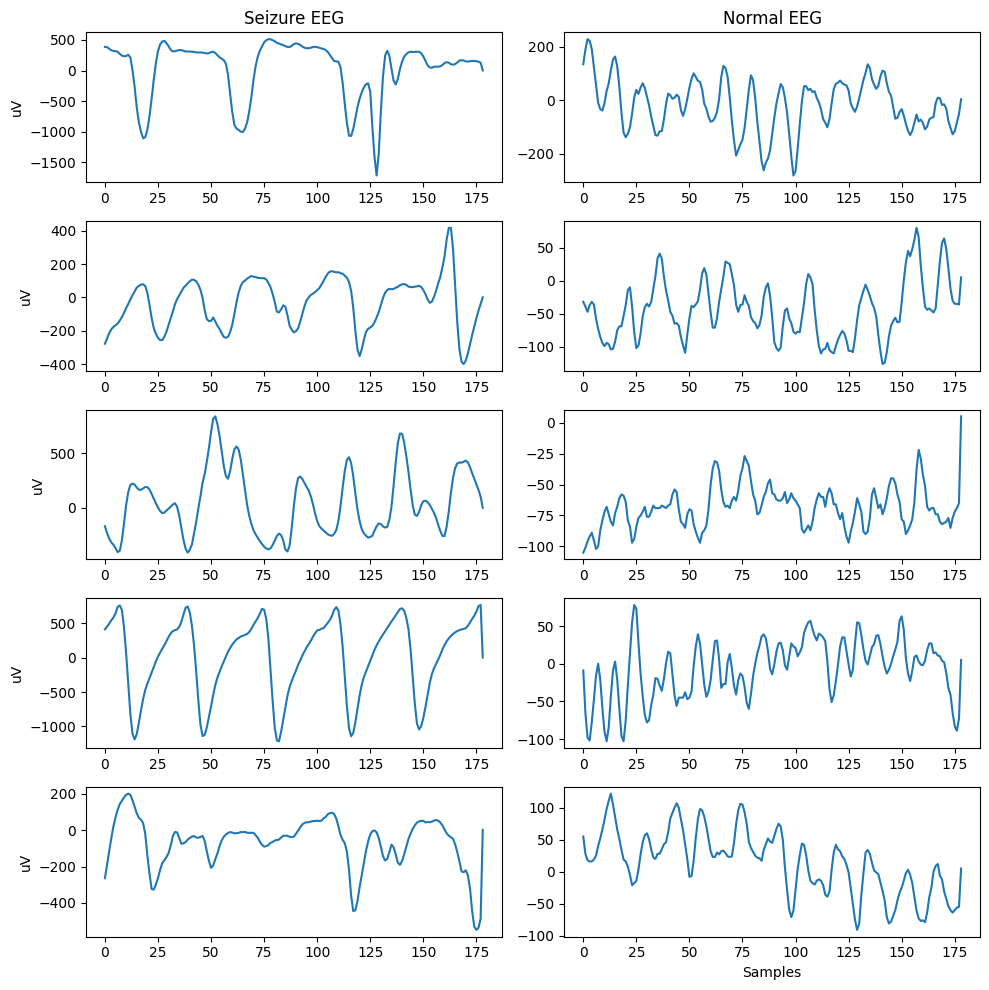

In [21]:
def plot_some_samples(data, seizure_index_list, normal_index_list):
    plt.figure(figsize=(10, 10))

    for i in range(5):
        plt.subplot(5, 2, 2*i + 1)
        if i == 0:
            plt.title("Seizure EEG")
        plt.plot(data[seizure_index_list[i]])
        plt.ylabel("uV")

        plt.subplot(5, 2, 2*i + 2)
        if i == 0:
            plt.title("Normal EEG")
        plt.plot(data[normal_index_list[i]])

    plt.xlabel("Samples")
    plt.tight_layout()
    plt.show()

plot_some_samples(X, seizure_index_list, normal_index_list)

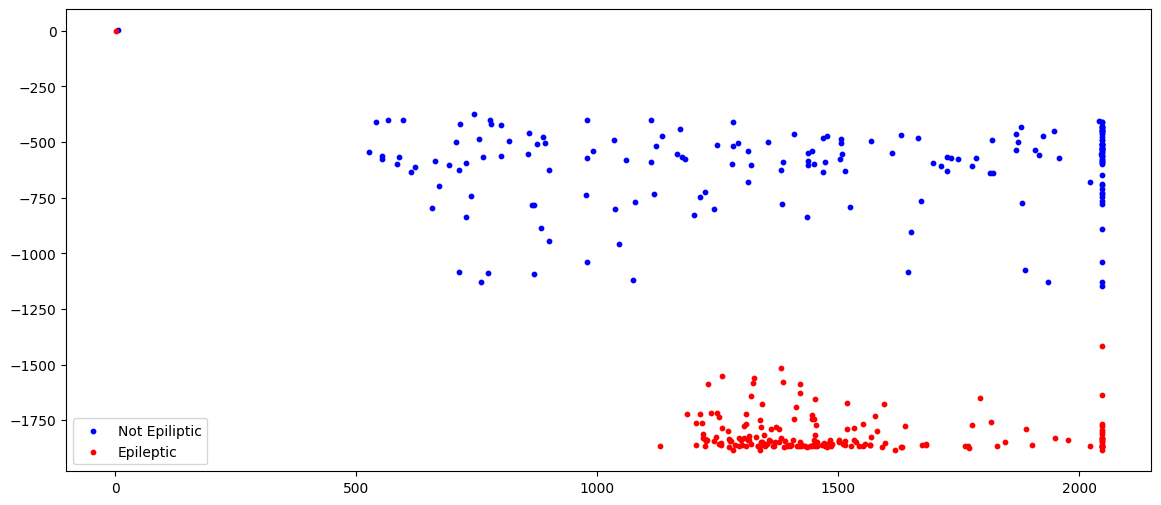

In [23]:
not_epileptic = [df[df['is_seizure']==0].iloc[:, range(0, len(df.columns)-2)].values]
epileptic = [df[df['is_seizure']==1].iloc[:, range(0, len(df.columns)-2)].values]
def indic(df):
    max = np.max(df, axis=1)
    min = np.min(df, axis=1)
    return max, min

x1,y1 = indic(not_epileptic)
x2,y2 = indic(epileptic)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(111)

ax1.scatter(x1, y1, s=10, c='b', label='Not Epiliptic')
ax1.scatter(x2, y2, s=10, c='r', label='Epileptic')
plt.legend(loc='lower left');
plt.show()

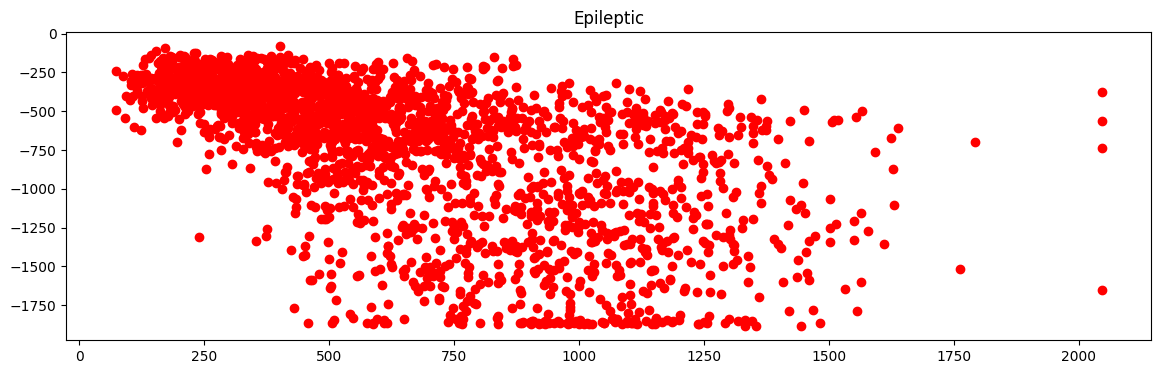

In [25]:
x,y = indic(df[df['is_seizure']==1].iloc[:, range(0, len(df.columns)-2)].values)
plt.figure(figsize=(14,4))
plt.title('Epileptic')
plt.scatter(x, y, c='r');

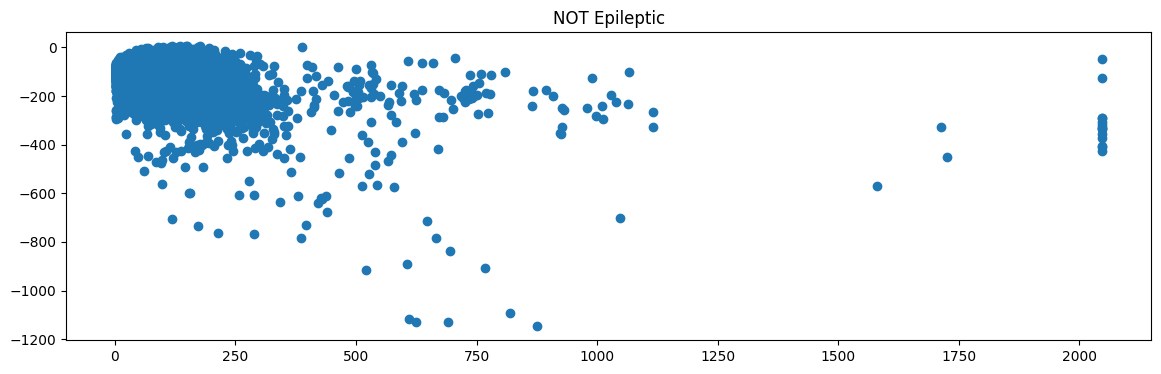

In [26]:
x,y = indic(df[df['is_seizure']==0].iloc[:, range(0, len(df.columns)-2)].values)
plt.figure(figsize=(14,4))
plt.title('NOT Epileptic')
plt.scatter(x, y);

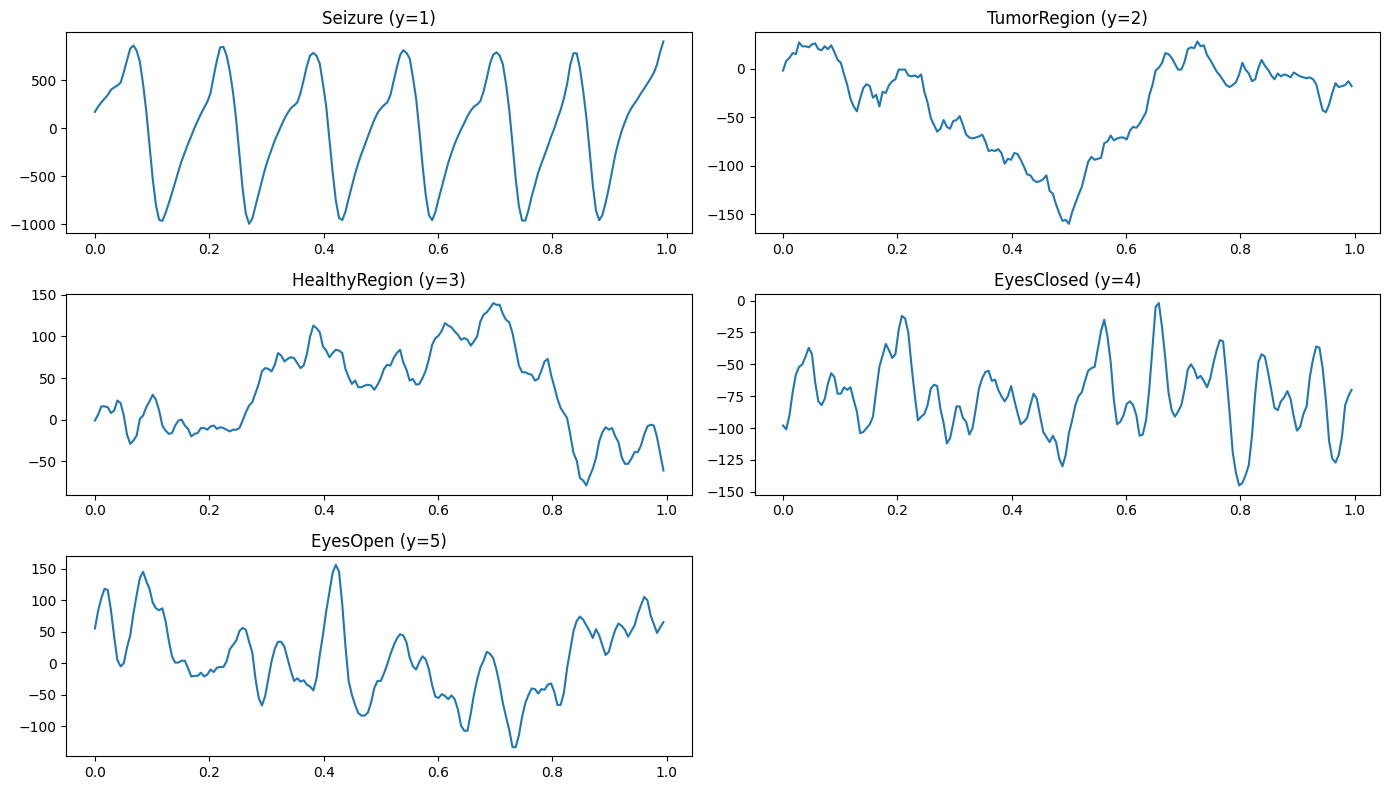

In [27]:
plt.figure(figsize=(14, 8))

for i, cls in enumerate(sorted(df[label_col].unique()), 1):
    s = (
        df[df[label_col] == cls][feature_col]
        .astype(float)
        .sample(1, random_state=cls)
        .values.flatten()
    )

    ax = plt.subplot(3, 2, i)
    ax.plot(np.arange(len(s)) / 178.0, s)
    ax.set_title(f'{label_map[cls]} (y={cls})')

plt.tight_layout()
plt.show()

In [54]:
def extract_time_feature(signal):
  signal = np.asarray(signal, dtype = float)
  feats = {
      'td_mean' : np.mean(signal),
      "td_std": np.std(signal),
      "td_rms": np.sqrt(np.mean(signal**2)),
      "td_kurtosis": kurtosis(signal),
      "td_skewness": skew(signal),
      "td_peak2peak": np.ptp(signal)
  }
  return feats

In [28]:


time_feature = df[feature_col].apply(lambda row: pd.Series(extract_time_feature(row)), axis = 1)
time_feature_df = pd.concat([time_feature, df[['label_name','is_seizure']]],axis = 1)

time_feature_df.head()

,td_mean,td_std,td_rms,td_kurtosis,td_skewness,td_peak2peak,label_name,is_seizure
0,-16.910112,95.710958,97.193309,0.067411,-0.200327,510.0,EyesClosed,0
1,28.112360,471.835823,472.672559,1.341888,-1.511088,2229.0,Seizure,1
2,-44.044944,44.186380,62.389048,-0.240414,0.494485,206.0,EyesOpen,0
3,-68.910112,15.923723,70.726010,0.212160,0.367125,83.0,EyesOpen,0
4,-6.651685,38.693001,39.260581,-0.250516,-0.462741,181.0,EyesOpen,0


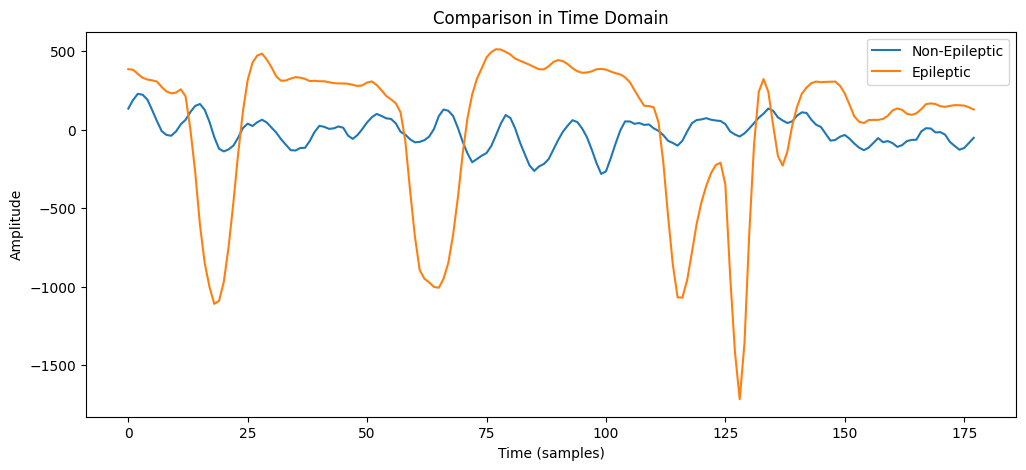

In [29]:
non_ep = df[df['is_seizure'] == 0][feature_col].iloc[0].values
ep = df[df['is_seizure'] == 1][feature_col].iloc[0].values

plt.figure(figsize=(12, 5))
plt.plot(non_ep, label="Non-Epileptic")
plt.plot(ep, label="Epileptic")
plt.title("Comparison in Time Domain")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

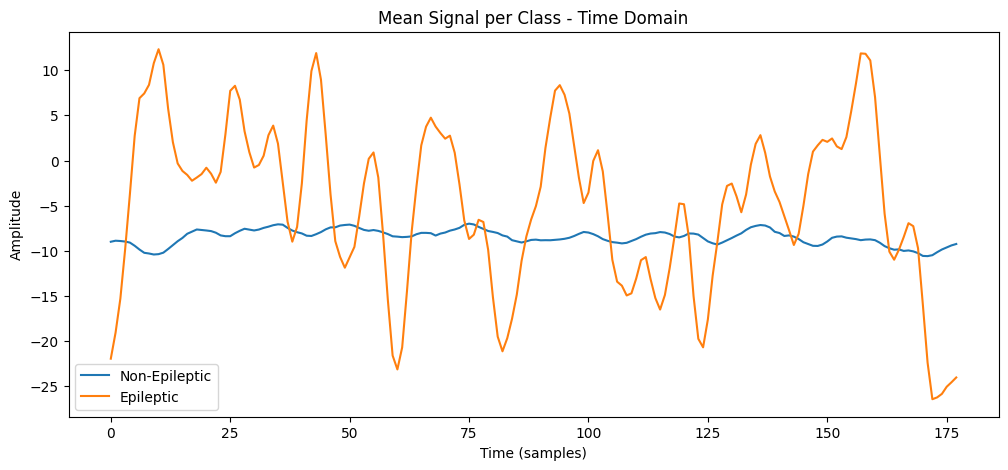

In [30]:
non_ep = df[df['is_seizure'] == 0][feature_col].mean().values
ep = df[df['is_seizure'] == 1][feature_col].mean().values

plt.figure(figsize=(12, 5))
plt.plot(non_ep, label="Non-Epileptic")
plt.plot(ep, label="Epileptic")
plt.title("Mean Signal per Class - Time Domain")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [31]:
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta':  (13, 30),
    'gamma': (30, 45)
}
fs = 178

In [32]:
def extract_bandpowers(signal, fs=fs):
    freqs, psd = welch(signal, fs=fs, nperseg=min(256, len(signal)))
    features = {}
    for band, (low, high) in bands.items():
        band_power = np.trapz(psd[(freqs >= low) & (freqs <= high)])
        features[f"band_{band}"] = band_power
    return features


In [33]:
signal = df.drop(["label_name","is_seizure"], axis=1).iloc[0].values.astype(float)

In [34]:
band_features = extract_bandpowers(signal, fs=fs)
print("Example Band Powers:")
band_features

Example Band Powers:


{'band_delta': np.float64(2556.2010982222696),
 'band_theta': np.float64(105.91937702564115),
 'band_alpha': np.float64(2965.2605932067763),
 'band_beta': np.float64(2668.3034706792178),
 'band_gamma': np.float64(52.31244189676234)}

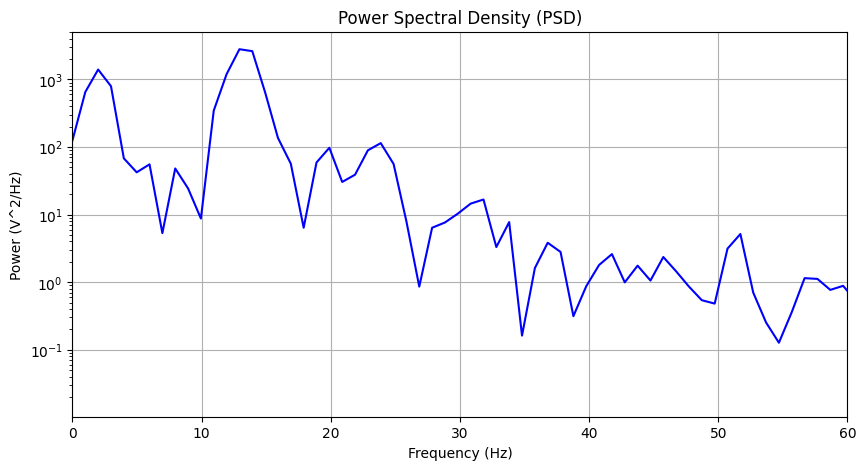

In [35]:
freqs, psd = welch(signal, fs=fs, nperseg=256)
plt.figure(figsize=(10,5))
plt.semilogy(freqs, psd, color="b")
plt.title("Power Spectral Density (PSD)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (V^2/Hz)")
plt.xlim(0, 60)
plt.grid(True)
plt.show()

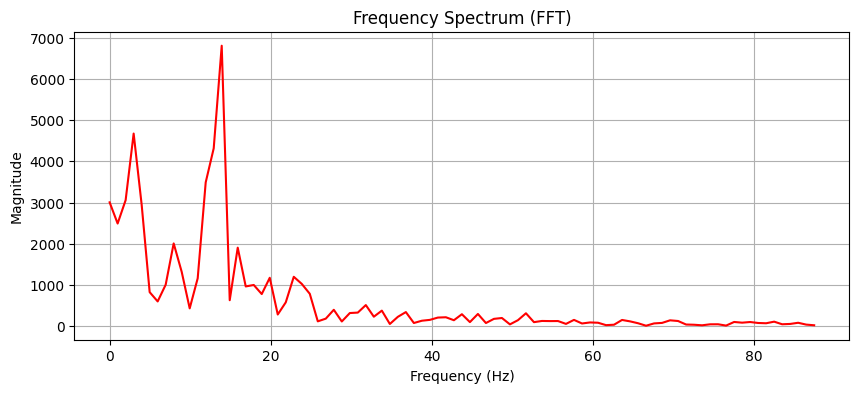

In [36]:
fft_vals = np.fft.fft(signal.astype(np.float64))
fft_freqs = np.fft.fftfreq(len(signal), d=1/fs)
freqs = fft_freqs[:len(fft_freqs)//2]
magnitudes = np.abs(fft_vals[:len(fft_vals)//2])

plt.figure(figsize=(10,4))
plt.plot(freqs, magnitudes, color='r')
plt.title("Frequency Spectrum (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()

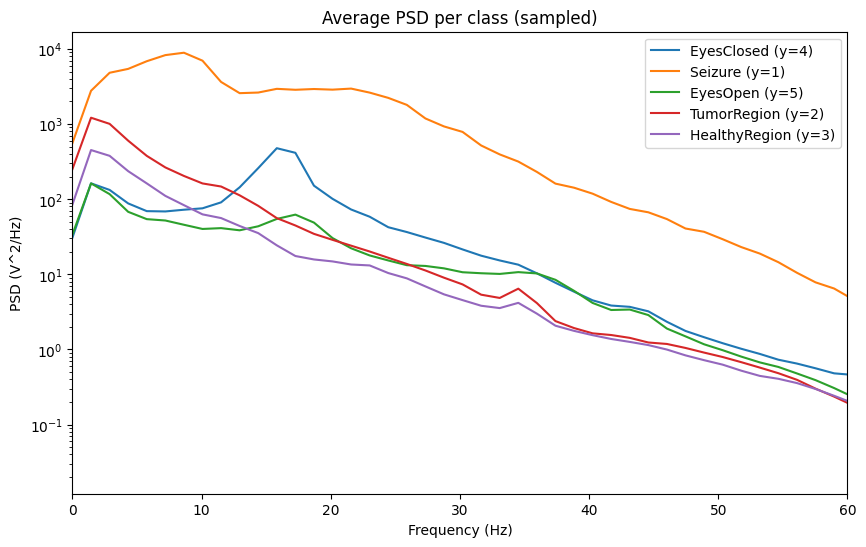

In [37]:
avg_psds = {}
for cls in df['y'].unique():
    data_cls = df[df['y']==cls][feature_col].values
    psds = []
    for row in data_cls:
        f, Pxx = welch(row, fs=256, nperseg=256)
        psds.append(Pxx)
    avg_psds[cls] = (f, np.mean(psds, axis=0))

plt.figure(figsize=(10,6))
for cls,(f,pavg) in avg_psds.items():
    plt.semilogy(f, pavg, label=f'{label_map[cls]} (y={cls})')
plt.xlim(0,60)
plt.xlabel('Frequency (Hz)'); plt.ylabel('PSD (V^2/Hz)')
plt.legend(); plt.title('Average PSD per class (sampled)')
plt.show()

In [38]:
features_list = []
for i, row in df.iterrows():
    signal = row.drop(["label_name","is_seizure"]).values.astype(float)
    band_feats = extract_bandpowers(signal, fs=fs)
    band_feats["label_name"] = row["label_name"]
    band_feats["is_seizure"] = row["is_seizure"]
    features_list.append(band_feats)

freq_features_df = pd.DataFrame(features_list)
freq_features_df.head()

,band_delta,band_theta,band_alpha,band_beta,band_gamma,label_name,is_seizure
0,2556.201098,105.919377,2965.260593,2668.303471,52.312442,EyesClosed,0
1,142296.258330,45538.328953,18321.536625,26316.597992,423.885016,Seizure,1
2,294.885706,246.578162,247.003551,442.081154,5.718420,EyesOpen,0
3,68.059939,21.653563,50.683193,58.561110,1.646552,EyesOpen,0
4,222.243124,90.893221,91.408302,299.006969,21.359992,EyesOpen,0


In [39]:
freq_features=freq_features_df.drop(['label_name','is_seizure'],axis=1)

In [40]:
data=pd.concat([df,time_feature,freq_features],axis=1)
data.columns[-20:]

Index(['X173', 'X174', 'X175', 'X176', 'X177', 'X178', 'y', 'label_name',
       'is_seizure', 'td_mean', 'td_std', 'td_rms', 'td_kurtosis',
       'td_skewness', 'td_peak2peak', 'band_delta', 'band_theta', 'band_alpha',
       'band_beta', 'band_gamma'],
      dtype='object')

In [41]:
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,td_std,td_rms,td_kurtosis,td_skewness,td_peak2peak,band_delta,band_theta,band_alpha,band_beta,band_gamma
0,135,190,229,223,192,125,55,-9,-33,-38,...,95.710958,97.193309,0.067411,-0.200327,510.0,2556.201098,105.919377,2965.260593,2668.303471,52.312442
1,386,382,356,331,320,315,307,272,244,232,...,471.835823,472.672559,1.341888,-1.511088,2229.0,142296.258330,45538.328953,18321.536625,26316.597992,423.885016
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,44.186380,62.389048,-0.240414,0.494485,206.0,294.885706,246.578162,247.003551,442.081154,5.718420
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,15.923723,70.726010,0.212160,0.367125,83.0,68.059939,21.653563,50.683193,58.561110,1.646552
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,38.693001,39.260581,-0.250516,-0.462741,181.0,222.243124,90.893221,91.408302,299.006969,21.359992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,...,38.268536,38.614488,-0.966425,-0.185539,152.0,410.510633,327.735331,24.633521,10.916232,2.252225
11496,-47,-11,28,77,141,211,246,240,193,136,...,163.078548,163.177232,0.523230,0.009039,859.0,1911.700417,7277.688610,2790.234708,2013.483814,34.784466
11497,14,6,-13,-16,10,26,27,-9,4,14,...,44.164855,44.678125,-0.410145,0.092115,211.0,462.683814,23.719634,124.193819,562.832798,97.176369
11498,-40,-25,-9,-12,-2,12,7,19,22,29,...,63.428346,74.376812,0.272000,0.519187,305.0,581.348600,313.841646,480.194161,172.752122,6.123682


In [42]:
data.drop(['y','label_name'],axis=1,inplace=True)

In [43]:
X=data.drop('is_seizure',axis=1)
y=data['is_seizure']

In [44]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=40,shuffle=True,stratify=y)

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost" :XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,50), max_iter=300, random_state=42)
}

In [47]:
for name, model in models.items():
    if name in ["SVM", "Logistic Regression", "MLP"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.9661
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1840
           1       0.96      0.87      0.91       460

    accuracy                           0.97      2300
   macro avg       0.96      0.93      0.95      2300
weighted avg       0.97      0.97      0.97      2300

SVM Accuracy: 0.9743
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1840
           1       0.96      0.91      0.93       460

    accuracy                           0.97      2300
   macro avg       0.97      0.95      0.96      2300
weighted avg       0.97      0.97      0.97      2300

Random Forest Accuracy: 0.9817
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.95      0.96      0.95       460

    accuracy                           0.98      2300
   macro avg       0.97      0.97      

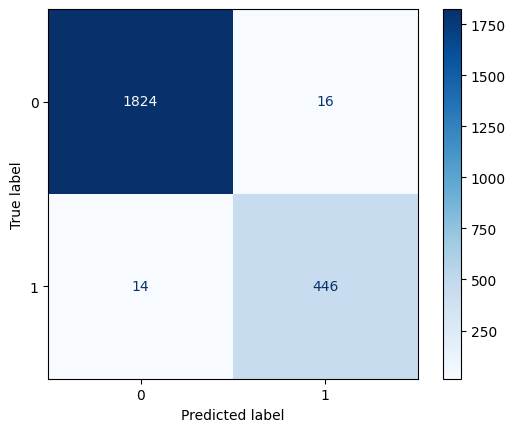

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
best_model = models["XGBoost"]
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")

In [50]:
best_model.save_model("xgb_model.json")

In [57]:
def extract_features(signal):
    signal = np.asarray(signal, dtype=float)

    raw_feats = {f"X{i+1}": signal[i] for i in range(len(signal))}
    time_feats = extract_time_feature(signal)
    band_feats = extract_bandpowers(signal, fs=fs)

    all_feats = {**raw_feats, **time_feats, **band_feats}

    return np.array(list(all_feats.values())).reshape(1, -1)

In [58]:
import joblib
import xgboost as xgb

model = xgb.XGBClassifier()
model.load_model("xgb_model.json")

def predict_from_signal(signal):
    features = extract_features(signal)

    pred_class = model.predict(features)[0]
    pred_proba = model.predict_proba(features)[0]

    return {
        "predicted_class": int(pred_class),
        "class_name": "Seizure" if pred_class == 1 else "Non-Seizure",
        "probabilities": pred_proba.tolist()
    }

In [66]:
df_test = pd.read_csv('/content/Epileptic Seizure Recognition.csv')

if 'Unnamed' in df_test.columns[0]:
    df_test = df_test.drop(df_test.columns[0], axis=1)

sample_signal = df_test.iloc[0, :-1].astype(float).values

predict_from_signal(sample_signal)

{'predicted_class': 0,
 'class_name': 'Non-Seizure',
 'probabilities': [0.9822045564651489, 0.017795445397496223]}